In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import load_model

#Load previously saved model
model = load_model('./model_savepoint')

Using TensorFlow backend.


In [3]:
#Check model structure
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
__________

In [4]:
#Choose the image and set target size (must match the original input size of the model)
infected_image = './train_2/Parasitized/C115P76ThinF_IMG_20150930_161825_cell_220.png'
TARGET_SIZE=(64,64)

In [36]:
#Preprocess image into a 4D tensor
from keras.preprocessing import image

#Load image
original_img = image.load_img(infected_image)
img = image.load_img(infected_image,target_size = TARGET_SIZE)
#Convert image to array
base_img = image.img_to_array(img)
#Add dimension to 4D
img_tensor = np.expand_dims(base_img, axis=0)

# #Rescale values as per the training set
img_tensor /= 255

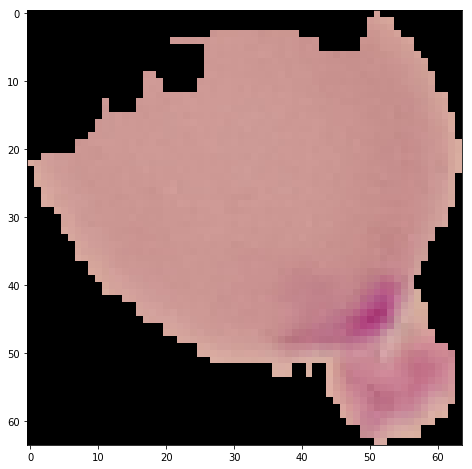

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,8))
plt.imshow(img_tensor[0])

In [7]:
import keras.backend as K

In [8]:
#Retrieve the final convolutional layer 
conv_layer = model.layers[-6]

#Retrieve the gradients of the infected class with regard to the output feature map of the last convolutional layer
gradients = K.gradients(model.output, conv_layer.output)[0]

#Retrieve the mean of the gradients over each of the 64 feature maps
mean_gradients = K.mean(gradients, axis=(0,1,2))

In [9]:
#This function will retrieve the mean gradients declared above, as well as the output feature map
extractor_fn = K.function([model.input], [mean_gradients, conv_layer.output[0]])

#Use function to retrieve mean gradients and output feature maps from the image passed into it
mean_grad_vals, conv_output = extractor_fn([img_tensor])        

#Useful only if more than 2 classes
num_classes = model.layers[-1].output.shape[1]

In [10]:
#useful only if more than 2 classes
for i in range(num_classes):
    conv_output[:, :, i] *= mean_grad_vals[i]

#Retrieve the channel-wise mean of the resulting feature map
heatmap = np.mean(conv_output, axis=-1)

#Normalise the heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

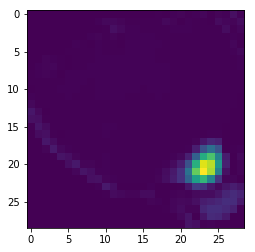

In [117]:
plt.imshow(heatmap)

In [76]:
import cv2
#Resize the cam_image to match original image, [:2][::1] is to ensure width and height are in the correct order
upsized_cam_image = cv2.resize(heatmap,cv2.imread(infected_image).shape[:2][::-1])

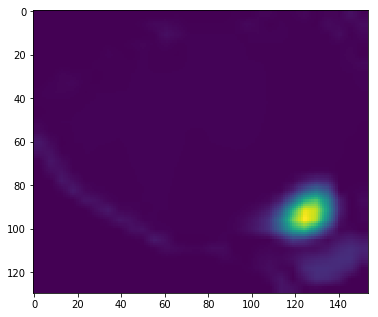

In [78]:
#Display the cam image
plt.figure(figsize=(6,6))
plt.imshow(upsized_cam_image)

In [70]:
im(infected_image).shape[:2][::-1]

(154, 130)

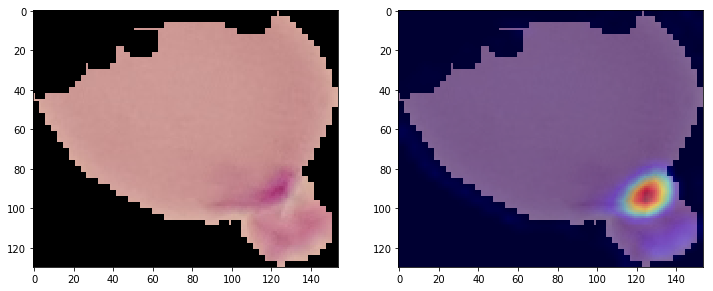

In [59]:
#Create plot of original image and image with grad cam
fig, ax = plt.subplots(1,2,figsize=(12,6))

#plot the original image on the left
ax[0].imshow(original_img)

#Rescale values to match original
final_heatmap = np.uint8(255*upsized_cam_image) 

#plot the original image on the right
ax[1].imshow(original_img)
# overlay original image on the right with heatmap of (red = strongest, blue = weakest)
ax[1].imshow(final_heatmap, alpha=0.4, cmap='jet')